# Example of NaiveFea

The aim of the project is running as fast as the reporter. (But it has a low level of knowledge now.)

## 1. Fundamental operation

In [1]:
import numpy as np
import meshio
import naivefea
from naivefea.constitutive import LinearMaterial
from naivefea.analysis import LinearFea

In [2]:
# import a mesh
mesh=meshio.read('abaqus_mesh.inp')

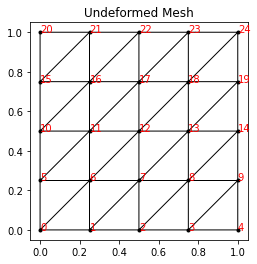

In [3]:
# instantiate fea according to mesh
fea=LinearFea(mesh)
# show the mesh, default plots node index but no element index
fea.plot_mesh()

In [4]:
# set material
material=LinearMaterial(E=10.0,nv=0.3)
fea.uniform_material(material)

In [5]:
# set boundary conditions
# left bound is fixed, and right bound apply fx=1.0
node_fix=[0,5,10,15,20]
f_given={14:(0.001,0)}
fea.set_deform_conditions('fix',Uxy=node_fix)
fea.set_force_conditions(f_given)
# print condistions
print('x_fix=',fea.x_given_displace)
print('y_fix=',fea.y_given_displace)
print('f_given=',fea.f_given)

x_fix= {0: 0.0, 5: 0.0, 10: 0.0, 15: 0.0, 20: 0.0}
y_fix= {0: 0.0, 5: 0.0, 10: 0.0, 15: 0.0, 20: 0.0}
f_given= {14: (0.001, 0)}


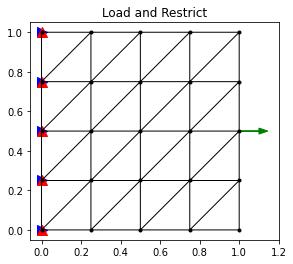

In [6]:
fea.plot_restrict()

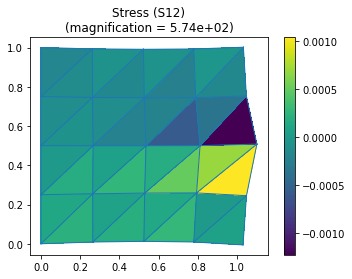

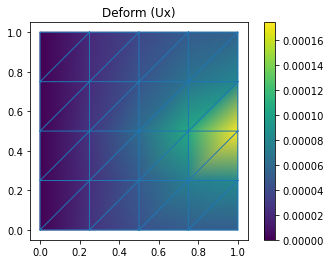

In [7]:
# submit for analyzing
fea.submit()
# show result, deformation and stress for example
fea.plot('stress','S12')
fea.plot('deform','Ux',deformed=False)
# all plot choice:
#   deform: Ux,   Uy
#   force:  Fx,   Fy
#   strain: e11,  e22,  e12
#   stress: S11,  S22,  S12

## 2. Advanced operation

### 2.1 Material

In [8]:
# set material name
material.set_name('rubber')
print(f"Name of the defined material is '{material.name}'.")

Name of the defined material is 'rubber'.


In [9]:
# you can choose material in database
from naivefea.constitutive import database
material_new=database.choose('steel')
print(f"Name of the choosed material is '{material_new.name}'.")

Name of the choosed material is 'default steel'.


### 2.2 Pre-process

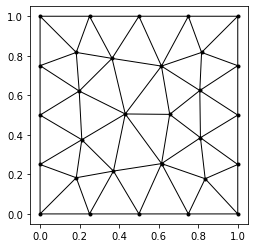

In [10]:
# generate mesh by pygmsh
import pygmsh
with pygmsh.geo.Geometry() as geom:
    geom.add_polygon(
        [
            [0.0, 0.0],
            [1.0, 0.0],
            [1.0, 1.0],
            [0.0, 1.0],
        ],
        mesh_size=0.3,
    )
    mesh_new = geom.generate_mesh()
# use plot_mesh view mesh before instantiate Fea by it
naivefea.plot_mesh(mesh_new)

Conditions may have been changed! Please resubmit for new result.
Conditions may have been changed! Please resubmit for new result.
Conditions may have been changed! Please resubmit for new result.
x_fix= {0: 0.0, 5: 0.0, 10: 0.0, 15: 0.0, 20: 0.0}
y_fix= {0: 0.0, 5: 0.0, 10: 0.0, 15: 0.0, 20: 0.0, 2: 5e-05, 22: -5e-05}
f_given= {14: (0.001, 0.0)}


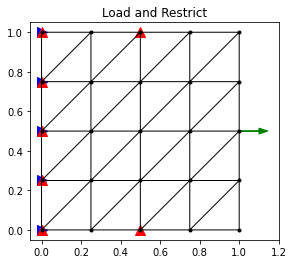

In [11]:
# set boundary conditions by geometry
# clear conditions set before
fea.clear_conditions('all')
# left bound is fixed, and right bound apply fx=1.0
node_fix=[]
f_given={}
for index,position in enumerate(mesh.points):
    x=position[0].tolist()
    y=position[1].tolist()
    if x<1e-6:
        node_fix.append(index)
    if 1.0-x<1e-6 and abs(y-0.5)<1e-2:
        f_given.update({index:(1.0e-3,0.0)})
fea.set_deform_conditions('fix',Uxy=node_fix)
fea.set_force_conditions(f_given)
# you can also set displacement, such as following
fea.set_deform_conditions('displace',Uy={2:5e-5,22:-5e-5},Uxy={12:(-5e-5,0.0)})
# if you want to clear deformation condition on node 14
fea.clear_node_conditions(12,'Uxy')
# print condistions
print('x_fix=',fea.x_given_displace)
print('y_fix=',fea.y_given_displace)
print('f_given=',fea.f_given)
fea.plot_restrict()

### 2.3 Post-process

In [12]:
fea.get_data('deform',14)

array([1.74278088e-04, 1.37160219e-05])

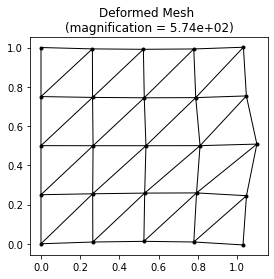

In [13]:
# plot is used for post-process
# so default plot of mesh is deformed
fea.plot('mesh')

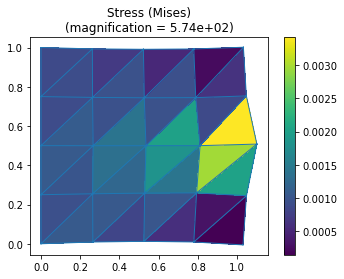

In [14]:
# show more variable
fea.cal_variable('Mises')
fea.plot('stress','Mises')

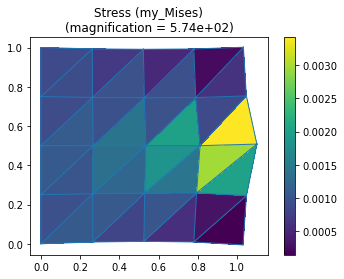

In [15]:
# calculate user defined show data and show it.
s11=fea.current_dict['stress']['S11']
s22=fea.current_dict['stress']['S22']
s12=fea.current_dict['stress']['S12']
my_Mises=np.sqrt(0.5*(s11**2+s22**2+(s11-s22)**2+6*s12**2))
fea.current_dict['stress']['my_Mises']=my_Mises
fea.plot('stress','my_Mises')